# Introduction

This notebook splits both background and signal .npy data into train, test and val sets containing both classes, and store them into HDF5 datasets. These datasets will be accessed by the classifier like numpy arrays, saving memory and enabling larger datasets. This is necessary on Squirrel since it only has ~100G memory in total, and images for 100k events can easily take ~8GB memory. 

It might appear messy to use 3 intermediate formats: .csv for showered events, .npy for event/jet images and .hdf5 for splitted dataset, but I think this might be handy if we want to adjust dataset split or composition during CNN tuning: if we use only .csv from pythia and .hdf5, then we need to generate event image every time we need new train/test/val sets, which takes ~ 15 mins for 100k events, and so far there are ~ 500k events in total for 3 higgs processes.

In [1]:
import numpy as np
import h5py
import save_and_load
import matplotlib.pyplot as plt
import os

## Reading data

In [2]:
# Load in event info and images produced by file-processing.ipynb
# Will use 8.1% memory
background_event_list, signal_event_list, background_mass_list, signal_mass_list,\
        background_weight, signal_weight, background_image_list, signal_image_list,\
        background_recluster_images, signal_recluster_images = save_and_load.load('hbb-qcd') 
print('finished')

finished


## Splitting data

In [3]:
# Function that splits whole event dataset into test, train and evaluation sets.
# the *_cut outputs has a 115<mass<135 cut.
rsplit = np.array([0.5,0.75])

def split_data(background_image_list,signal_image_list, cut=False):
    try:
        input_shape = background_image_list[0].shape
    except AttributeError:
        input_shape = (0)
        
    b_split = np.split(background_image_list,(len(background_image_list)*rsplit).astype(int))
    s_split = np.split(signal_image_list,(len(signal_image_list)*rsplit).astype(int))
    bm_split = np.split(background_mass_list,(len(background_mass_list)*rsplit).astype(int))
    sm_split = np.split(signal_mass_list,(len(signal_mass_list)*rsplit).astype(int))
    
    x_train = np.concatenate((b_split[0],s_split[0]))
    y_train = np.array(np.concatenate((np.zeros(len(b_split[0])),np.ones(len(s_split[0])))))
    mass_train = np.concatenate((bm_split[0],sm_split[0]))
    
    x_val = np.concatenate((b_split[1],s_split[1]))
    y_val = np.array(np.concatenate((np.zeros(len(b_split[1])),np.ones(len(s_split[1])))))
    mass_val = np.concatenate((bm_split[1],sm_split[1]))
    
    x_test = np.concatenate((b_split[2],s_split[2]))
    y_test = np.array(np.concatenate((np.zeros(len(b_split[2])),np.ones(len(s_split[2])))))
    mass_test = np.concatenate((bm_split[2],sm_split[2]))
    
    # Output dataset with mass cut
    if cut:
        x_train_cut = [] #Note that we *train* on this cut sample, but *test* on the whole thing I guess
        y_train_cut = []
        mass_train_cut = []
        for x in reversed(range(len(x_train))):
            if mass_train[x] < 135 and mass_train[x] > 115:
                x_train_cut.append(x_train[x])
                y_train_cut.append(y_train[x])
                mass_train_cut.append(mass_train[x])
        x_train_cut = np.array(x_train_cut)
        y_train_cut = np.array(y_train_cut)
        mass_train_cut = np.array(mass_train_cut)

        x_val_cut = [] 
        y_val_cut = []
        mass_val_cut = []
        for x in reversed(range(len(x_val))):
            if mass_val[x] < 135 and mass_val[x] > 115:
                x_val_cut.append(x_val[x])
                y_val_cut.append(y_val[x])
                mass_val_cut.append(mass_val[x])
        x_val_cut = np.array(x_val_cut)
        y_val_cut = np.array(y_val_cut)
        mass_val_cut = np.array(mass_val_cut)

        x_test_cut = [] 
        y_test_cut = []
        mass_test_cut = []
        for x in reversed(range(len(x_test))):
            if mass_test[x] < 135 and mass_test[x] > 115:
                x_test_cut.append(x_test[x])
                y_test_cut.append(y_test[x])
                mass_test_cut.append(mass_test[x])
        x_test_cut = np.array(x_test_cut)
        y_test_cut = np.array(y_test_cut)
        mass_test_cut = np.array(mass_test_cut)
        return(input_shape,
               x_train_cut,y_train_cut,mass_train_cut,
               x_val_cut,y_val_cut,mass_val_cut,
               x_test_cut,y_test_cut,mass_test_cut,
               )
    return(input_shape,
           x_train,y_train,mass_train,
           x_val,y_val,mass_val,
           x_test,y_test,mass_test,
           )

Here is a background jet image:


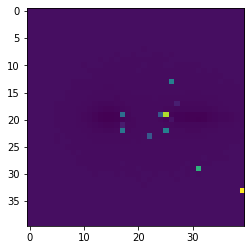

Here is a signal jet image:


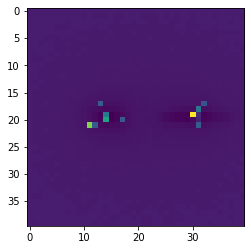

The datasets are always sorted background-first:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

In [4]:
# Split event images
# Uses ~3.5% memory
input_shape, \
    x_train,y_train,mass_train, \
    x_val,y_val,mass_val, \
    x_test,y_test,mass_test = split_data(background_image_list,signal_image_list)

# Split jet images
# Uses ~3.5% memory
input_shape_r, \
    x_train_r,y_train_r,mass_train_r, \
    x_val_r,y_val_r,mass_val_r, \
    x_test_r,y_test_r,mass_test_r = split_data(background_recluster_images,signal_recluster_images)

#FRANK print a jet image
print('Here is a background jet image:')
plt.imshow(x_train_r[0][0])
plt.show()

print('Here is a signal jet image:')
plt.imshow(x_train_r[-1][0])
plt.show()

print('The datasets are always sorted background-first:')
print(y_train[::100])
print(y_train_r[::100])


In [7]:
# Saving data to hdf5. ONLY RUN ONCE.
# Event images

# Deleting old files
!rm -rf ./event-image-hdf5/
os.makedirs('event-image-hdf5')

# Train set
f_train = h5py.File("event-image-hdf5/train.hdf5", "w")
f_train.create_dataset("x_train", data=x_train)
f_train.create_dataset("y_train", data=y_train)
f_train.create_dataset("mass_train", data=mass_train)
f_train.create_dataset("input_shape", data=input_shape)

# Test set
f_test = h5py.File("event-image-hdf5/test.hdf5", "w")
f_test.create_dataset("x_test", data=x_test)
f_test.create_dataset("y_test", data=y_test)
f_test.create_dataset("input_shape", data=input_shape)

# Evaluation set
f_val = h5py.File("event-image-hdf5/val.hdf5", "w")
f_val.create_dataset("x_val", data=x_val)
f_val.create_dataset("y_val", data=y_val)
f_val.create_dataset("input_shape", data=input_shape)

# Closing files will write all changes
f_train.close()
f_test.close()
f_val.close()

%xdel x_train
%xdel y_train
%xdel mass_train
%xdel x_test
%xdel y_test
%xdel x_val
%xdel y_val
%xdel signal_mass_list

In [8]:
# Saving data to hdf5. ONLY RUN ONCE.
# Jet images

# Deleting old files
!rm -rf ./jet-image-hdf5/
os.makedirs('jet-image-hdf5')

# Train set
f_train_r = h5py.File("jet-image-hdf5/train_r.hdf5", "w")
f_train_r.create_dataset("x_train_r", data=x_train_r)
f_train_r.create_dataset("y_train_r", data=y_train_r)
f_train_r.create_dataset("mass_train_r", data=mass_train_r)
f_train_r.create_dataset("input_shape_r", data=input_shape_r)

# Test set
f_test_r = h5py.File("jet-image-hdf5/test_r.hdf5", "w")
f_test_r.create_dataset("x_test_r", data=x_test_r)
f_test_r.create_dataset("y_test_r", data=y_test_r)
f_test_r.create_dataset("input_shape_r", data=input_shape_r)

# Evaluation set
f_val_r = h5py.File("jet-image-hdf5/val_r.hdf5", "w")
f_val_r.create_dataset("x_val_r", data=x_val_r)
f_val_r.create_dataset("y_val_r", data=y_val_r)
f_val_r.create_dataset("input_shape_r", data=input_shape_r)

# Closing files will write all changes
f_train_r.close()
f_test_r.close()
f_val_r.close()

%xdel x_train_r
%xdel y_train_r
%xdel mass_train_r
%xdel x_test_r
%xdel y_test_r
%xdel x_val_r
%xdel y_val_r
%xdel signal_mass_list_r

NameError: name 'signal_mass_list_r' is not defined


In [11]:
print(input_shape)
print(type(input_shape))

(3, 40, 40)
<class 'tuple'>
